In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from typing import Literal, Optional
from sklearn.manifold import TSNE
from umap import UMAP
import itertools
from pathlib import Path
from loguru import logger
from matplotlib.axes import Axes

from histaug.utils import load_features

/app/env/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/app/env/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/app/env/lib/python3.9/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument was no

In [3]:
model = "ctranspath"
features = load_features(f"/data/histaug/results/kather100k/{model}.zarr", remove_classes=["BACK"])

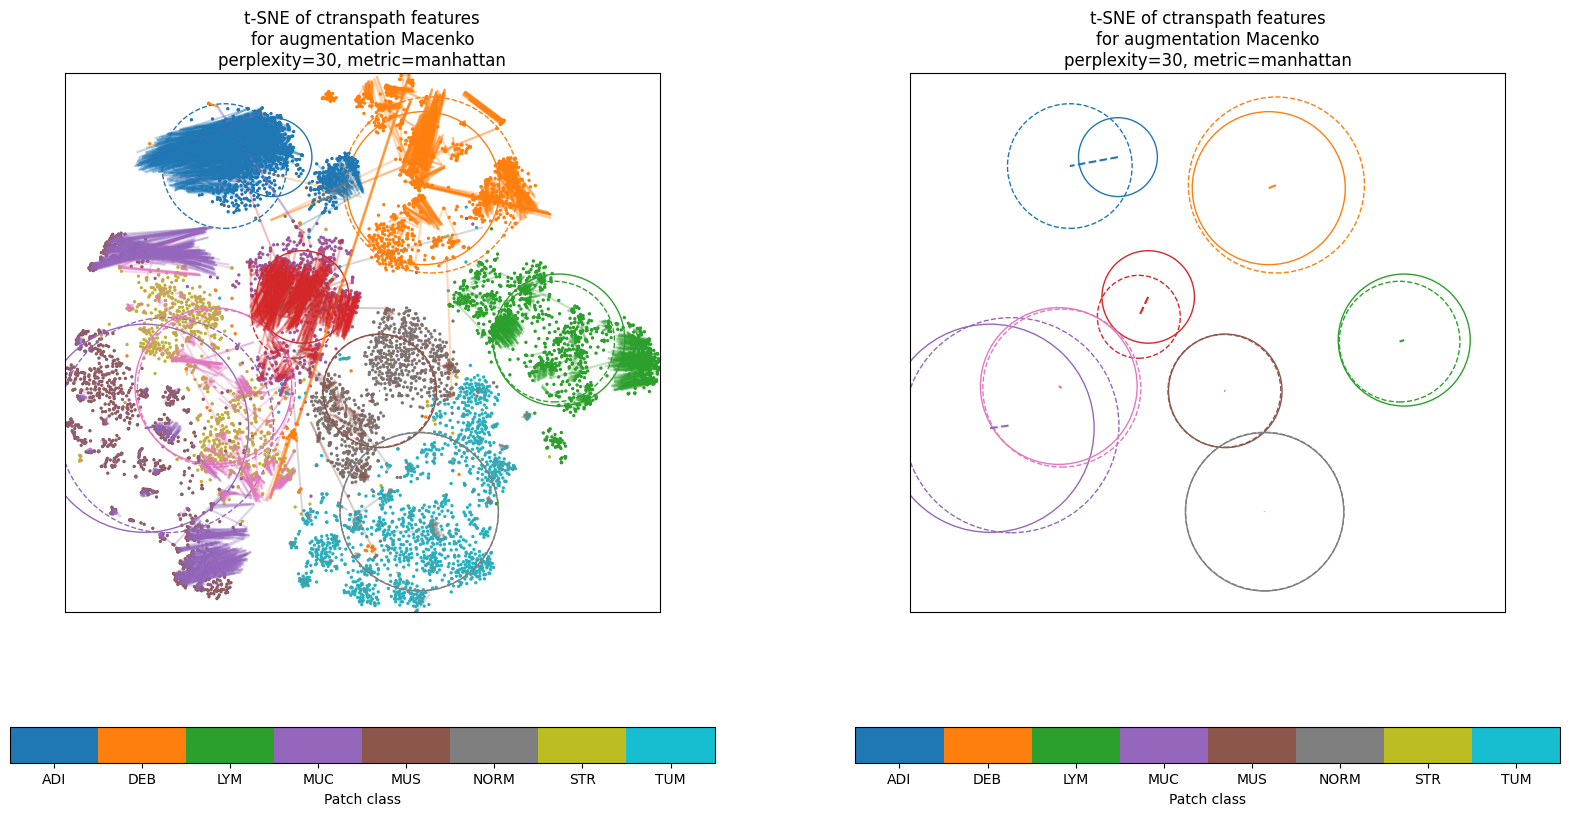

In [4]:
def visualize_embeddings(
    feats: np.ndarray,  # [n_samples, n_features]
    feats_aug: np.ndarray,  # [n_samples, n_features]
    labels: np.ndarray,  # [n_samples] (strings)
    augmentation: str,
    model: str,
    technique: Literal["tsne", "umap", "umap-separate"] = "tsne",
    metric: Literal["euclidean", "cosine", "manhattan"] = "euclidean",
    tsne_perplexity: int = 30,
    umap_n_neighbors: int = 50,
    umap_min_dist: float = 0.1,
    ax: Optional[Axes] = None,
    plot_feats: bool = True,  # plot the features and augmented features
    plot_centroids: bool = True,  # plot the centroids and their spread
    feats_embedded: Optional[
        np.ndarray
    ] = None,  # if None, compute using the specified technique (shape: [n_samples, 2])
    feats_aug_embedded: Optional[
        np.ndarray
    ] = None,  # if None, compute using the specified technique (shape: [n_samples, 2])
):
    classes = sorted(np.unique(labels))
    label2class = {label: i for i, label in enumerate(classes)}

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))

    # Generate embeddings using t-SNE
    if feats_embedded is None or feats_aug_embedded is None:
        feats_cat = np.concatenate([feats, feats_aug], axis=0)
        if technique == "tsne":
            feats_embedded = TSNE(
                n_components=2,
                learning_rate="auto",
                init="pca",
                random_state=0,
                perplexity=tsne_perplexity,
                metric=metric,
            ).fit_transform(feats_cat)
            feats_embedded, feats_aug_embedded = np.split(feats_embedded, 2, axis=0)
        elif technique == "umap":
            feats_embedded = UMAP(
                n_components=2, random_state=0, n_neighbors=umap_n_neighbors, min_dist=umap_min_dist, metric=metric
            ).fit_transform(feats_cat)
            feats_embedded, feats_aug_embedded = np.split(feats_embedded, 2, axis=0)
        elif technique == "umap-separate":
            umap = UMAP(
                n_components=2, random_state=0, n_neighbors=umap_n_neighbors, min_dist=umap_min_dist, metric=metric
            )
            feats_embedded = umap.fit_transform(feats)
            feats_aug_embedded = umap.transform(feats_aug)

    # Use a colormap to map labels to colors
    cmap = matplotlib.colormaps["tab10"]  # 'tab10' is a colormap suitable for categorical data up to 10 categories

    if plot_feats:
        # Draw lines and annotations
        for f, f_reflect, label in zip(feats_embedded, feats_aug_embedded, labels):
            # ax.plot([f[0], f_reflect[0]], [f[1], f_reflect[1]], c="k", alpha=0.1)
            ax.plot([f[0], f_reflect[0]], [f[1], f_reflect[1]], c=cmap.colors[label2class[label]], alpha=0.3)

        # Scatter plots
        ax.scatter(feats_embedded[:, 0], feats_embedded[:, 1], c=[label2class[l] for l in labels], s=2, cmap=cmap)

    # Add a colorbar to indicate which colors correspond to which labels
    norm = matplotlib.colors.Normalize(vmin=0, vmax=len(classes) - 1)
    sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = ax.get_figure().colorbar(
        mappable=sm, boundaries=np.arange(len(classes) + 1) - 0.5, orientation="horizontal", ax=ax
    )
    cbar.set_ticks(range(len(classes)))
    cbar.set_ticklabels(classes)
    cbar.set_label("Patch class")

    technique_kwargs = (
        dict(perplexity=tsne_perplexity)
        if technique == "tsne"
        else dict(n_neighbors=umap_n_neighbors, min_dist=umap_min_dist)
    )
    technique_kwargs["metric"] = metric
    technique_kwargs = ", ".join(f"{k}={v}" for k, v in technique_kwargs.items())
    ax.set_title(
        f"{'t-SNE' if technique == 'tsne' else 'UMAP'} of {model} features\nfor augmentation {augmentation}\n{technique_kwargs}"
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal", "box")

    if plot_centroids:
        # Compute centroids for each class
        centroids_per_class = {label: np.mean(feats_embedded[labels == label], axis=0) for label in classes}
        centroids_per_class_aug = {label: np.mean(feats_aug_embedded[labels == label], axis=0) for label in classes}

        # Compute spread for each class (mean distance to centroid)
        spread_per_class = {
            label: np.mean(np.linalg.norm(feats_embedded[labels == label] - centroids_per_class[label], axis=-1))
            for label in classes
        }
        spread_per_class_aug = {
            label: np.mean(
                np.linalg.norm(feats_aug_embedded[labels == label] - centroids_per_class_aug[label], axis=-1)
            )
            for label in classes
        }

        # Draw a circle around each centroid with radius equal to the spread
        for label in classes:
            ax.add_artist(
                plt.Circle(
                    centroids_per_class[label],
                    spread_per_class[label],
                    fill=False,
                    color=cmap.colors[label2class[label] % len(cmap.colors)],
                )
            )
            ax.add_artist(
                plt.Circle(
                    centroids_per_class_aug[label],
                    spread_per_class_aug[label],
                    fill=False,
                    color=cmap.colors[label2class[label] % len(cmap.colors)],
                    linestyle="--",
                )
            )

        # Draw a line between each centroid and its augmented counterpart
        for label in classes:
            ax.plot(
                [centroids_per_class[label][0], centroids_per_class_aug[label][0]],
                [centroids_per_class[label][1], centroids_per_class_aug[label][1]],
                c=cmap.colors[label2class[label] % len(cmap.colors)],
                linestyle="--",
            )

        all_feats_embedded = np.concatenate([feats_embedded, feats_aug_embedded], axis=0)
        plt.xlim(np.min(all_feats_embedded[:, 0]), np.max(all_feats_embedded[:, 0]))
        plt.ylim(np.min(all_feats_embedded[:, 1]), np.max(all_feats_embedded[:, 1]))

    return feats_embedded, feats_aug_embedded


augmentation = "Macenko"
# augmentation = "low saturation"
# augmentation = "rotate random angle"

metric = "cosine"
metric = "euclidean"
metric = "manhattan"

N = 10000
feats = features.feats[:N]
feats_aug = features.feats_augs[augmentation][:N]
labels = features.labels[:N]

technique_kwargs = dict(
    technique="tsne",
    tsne_perplexity=30,
)

# technique_kwargs = dict(
#     technique="umap",
#     umap_n_neighbors=50,
#     umap_min_dist=0.1,
# )

plt.figure(figsize=(20, 10))
plt.subplot(121)

feats_embedded, feats_aug_embedded = visualize_embeddings(
    feats=feats,
    feats_aug=feats_aug,
    labels=labels,
    augmentation=augmentation,
    metric=metric,
    model=model,
    **technique_kwargs,
    plot_centroids=True,
    plot_feats=True,
    ax=plt.gca(),
)

plt.subplot(122)

visualize_embeddings(
    feats=feats,
    feats_aug=feats_aug,
    labels=labels,
    augmentation=augmentation,
    metric=metric,
    model=model,
    **technique_kwargs,
    plot_centroids=True,
    plot_feats=False,
    ax=plt.gca(),
    feats_embedded=feats_embedded,
    feats_aug_embedded=feats_aug_embedded,
)

pass